In [1]:
geo='DE'  
age_ranges=[ 'Y_LT10', 'Y10-19', 'Y20-29', 'Y30-39', 'Y40-49', 'Y50-59', 'Y60-69', 'Y70-79', 'Y80-89', 'Y_GE90', 'TOTAL']
sex='T'

base_year=2020
years=range(base_year-8,base_year+1)

DEBUG=True

In [2]:
import os
import csv
import datetime
import sys
import gzip
import certifi
import urllib3
import io
from matplotlib import pyplot as plt

http=urllib3.PoolManager( cert_reqs='CERT_REQUIRED', ca_certs=certifi.where()) 

def open_eurostat_file(filename,localpath=os.getcwd()+'/Data/',remotepath='https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?file=data/'):
  if not os.path.exists(localpath+filename+'.gz'):
    if globals().get('DEBUG'): print(f'Downloading "{remotepath+filename}.gz" from Eurostat.')
    with http.request('GET',remotepath+filename+'.gz',preload_content=False) as r:
      if globals().get('DEBUG'): print(f'Saving "{localpath+filename}.gz" locally.')
      with open(localpath+filename+'.gz','wb') as f:
        f.write(r.read())
  if globals().get('DEBUG'): print(f'Loading local "{localpath+filename}.gz".')
  return gzip.open(localpath+filename+'.gz','rt',encoding='utf8')

def extract_eurostat_data(file='demo_r_mwk_10.tsv', filter={'geo':'DE','sex':'T'}, fields=('age','year','week','value')):
  with open_eurostat_file(file) as f:
    Table=csv.DictReader(f,delimiter='\t')
    rowparamkeys=(Table.fieldnames[0].split('\\')[0]).split(',')
    for rec in Table:
      fields_={key:value for key,value in zip(rowparamkeys,rec[Table.fieldnames[0]].split(','))}
      if sum([fields_[key]!=value for key,value in filter.items()])==0:
        for key,value in rec.items():
          if key!=Table.fieldnames[0]:
            if 'W' in key:
              year,week=key.split('W')
            else:
              year=key
              week=0
            fields_['year']=int(year)
            fields_['week']=int(week)
            val=value.split()[0]
            fields_['value']=int(val) if val.isnumeric() else 0
            yield(fields_[key] for key in fields)


In [3]:
db_={}
for age,year,week,val in extract_eurostat_data('demo_r_mwk_10.tsv',filter={'geo':geo,'sex':sex}, fields=('age','year','week','value')):
  if not age in db_:
    db_[age]=dict([])
  if not year in db_[age]:
    db_[age][year]=[0]*54
  if week<54:
   db_[age][year][week]=val
  else:
    if week!=99:
      print(week)
      
db={age:{year:sum(weeks) for year,weeks in years.items()} for age,years in db_.items()}#sum over weeks


Loading local "/private/var/mobile/Containers/Data/Application/4ADCFE5A-AA83-49C5-9A88-90B64EABBD94/tmp/(A Document Being Saved By Carnets)/Eurostat/Data/demo_r_mwk_10.tsv.gz".


In [4]:
db1={}
for age,year,val in extract_eurostat_data('demo_pjan.tsv',filter={'geo':geo,'sex':sex}, fields=('age','year','value')):
  if age=='Y_LT1':
    age='Y0'
  if age=='Y_OPEN':
    age='Y_GE90'
  if age[:1]=='Y':
    if (age[1:]).isnumeric():
      age=int(age[1:])
      if age<10:
        age='Y_LT10'
      elif age>=90:
        age='Y_GE90'
      else:
        age=f'Y{age//10*10:2d}-{age//10*10+9:2d}'
  if not age in db1:
    db1[age]=dict([])
  if not year in db1[age]:
    db1[age][year]=0
  db1[age][year]+=val


Loading local "/private/var/mobile/Containers/Data/Application/4ADCFE5A-AA83-49C5-9A88-90B64EABBD94/tmp/(A Document Being Saved By Carnets)/Eurostat/Data/demo_pjan.tsv.gz".


In [5]:
db2={}
for age in age_ranges:
  db2[age]={}
  for year in years:
    x=db[age][year]/db1[age][year-1]
    db2[age][year]=x   

db2['age-adj 2020']={}
for year in years:
  s=0
  for age in age_ranges[:-1]:
    s+=db[age][year]/db1[age][year-1]*db1[age][base_year-1]
  x=s/db1["TOTAL"][base_year-1]
  db2['age-adj 2020'][year]=x
    
print(f'{"age-range|years:":16s}{"".join([f" {y:6d}" for y in years])}')      
for age,row in db2.items():
  print(f'{age:16s}',end=' ')   
  print(''.join([f'{db2[age][year]*100.0:6.3f} ' for year in years]))


age-range|years:   2012   2013   2014   2015   2016   2017   2018   2019   2020
Y_LT10            0.000  0.000  0.000  0.000  0.049  0.045  0.045  0.043  0.041 
Y10-19            0.000  0.000  0.000  0.000  0.017  0.015  0.016  0.015  0.014 
Y20-29            0.000  0.000  0.000  0.000  0.034  0.032  0.033  0.031  0.031 
Y30-39            0.000  0.000  0.000  0.000  0.065  0.064  0.063  0.062  0.063 
Y40-49            0.000  0.000  0.000  0.000  0.156  0.148  0.150  0.144  0.148 
Y50-59            0.000  0.000  0.000  0.000  0.462  0.445  0.446  0.425  0.421 
Y60-69            0.000  0.000  0.000  0.000  1.176  1.155  1.167  1.132  1.134 
Y70-79            0.000  0.000  0.000  0.000  2.531  2.599  2.651  2.580  2.588 
Y80-89            0.000  0.000  0.000  0.000  8.441  8.431  8.344  7.974  8.121 
Y_GE90            0.000  0.000  0.000  0.000 23.989 24.780 24.762 23.957 24.795 
TOTAL             0.000  0.000  0.000  0.000  1.116  1.131  1.154  1.131  1.171 
age-adj 2020      0.000  0.00

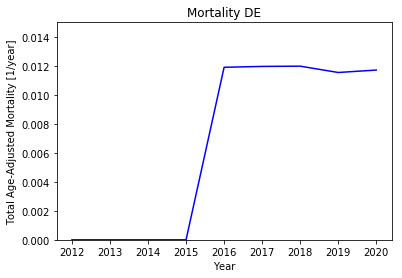

In [6]:
%matplotlib inline
plt.close()
plt.ylim(0,0.015)
plt.ylabel('Total Age-Adjusted Mortality [1/year]')
plt.xlabel('Year')
plt.title(f'Mortality {geo}')
plt.plot(years,list(db2['age-adj 2020'].values()),'b')
plt.show()

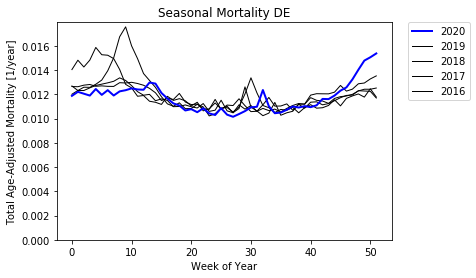

In [7]:
plt.close()
for year,weeks in db_['TOTAL'].items() :
    if (not (year in years)) or (db2['TOTAL'][year]==0):
        continue
    last_week=len(weeks)
    while weeks[last_week-1]==0 and last_week>0:
      last_week-=1
    age_adj=db2['age-adj 2020'][year]/db2['TOTAL'][year]
#    age_adj=1.0
    plt.plot([age_adj*y/db1["TOTAL"][year-1]*365.25/7 for y in weeks[1:last_week]], 
     **([dict(c='k',lw=1,zorder=0), dict(c='b',lw=2,zorder=1,),][year==base_year]),
        label=f'{year}')
plt.ylabel('Total Age-Adjusted Mortality [1/year]')
plt.xlabel('Week of Year')
plt.title(f'Seasonal Mortality {geo}')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.ylim(bottom=0)
plt.show()

In [8]:
year=2016
age_adj=db2['age-adj 2020'][year]/db2['TOTAL'][year]
print(db2['age-adj 2020'][year])
print(sum([age_adj*y/db1["TOTAL"][year-1]*365.25/7 for y in db_['TOTAL'][year][1:]])/(365.25/7))

0.011900749098673278
0.011900749098673278
